# Telco Classification Project

![](telco_churn_pic.png)

In [1]:
from scipy import stats

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns

from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import os

import graphviz
from graphviz import Graph

import env
from acquire_telco import get_telco_data, summarize_telco
from prepare_telco import clean_telco, remove_unwanted_values, train_validate_test_split, num_distributions
from helper import splitting_target_var, get_final_report, pred_proba, make_predictions
from telco_model import baseline_acc, rand_forest, knneighbors, tree_model
from model_report import model_report
import explore

import warnings
warnings.filterwarnings("ignore")

## Planning

- Make a README.md that will hold all of the project details including a data dictionary, key finding, initial hypotheses, and explain how my process can be replicated
- Create a MVP, originally and work through the iterative process of making improvements to that MVP.
- Define atleast 2 clear sets of null and alternative hypotheses set an alpha value.
- Create two .py scripts for both acquire and prepare, in order to automate the collection and cleaning of the data.
- Create a helper.py for any other functions I need implamented thoughout the pipeline.
- Properly anotate my code as I run though the process, in order for the code to be easily understood, and document any decisions that were made when cleaning, creating new columns, or removing rows of data.

### Data Science Pipeline
##### Acquire
- Create an acquire.py (acquire_telco.py) was the name of my py file.
- Use that acquire_telco.py file to grab the data from the CodeUp SQL database and cache that file to a csv for ease of accessability.
- Render the csv into a pandas dataframe on python.
- Summarize the initial data and plot the distributions of individual variables.
##### Prepare
- Create a prepare.py (prepare_telco.py) was the name of my py file.
- Clean the data as I see fit, handling the missing values and encoding values as necessary in order to give numeric values that will work with the models
- There were 11 values with no current tenure, and I made the decision to remove those values. These customers have not payed their first bill, so there is no data on weather they are satisfied with the product.
- Add new columns that might be useful in modeling, might need more information from the explore for incite into columns that once combined will drive churn.
- I added two new columns (auto_pay - if payment type was automatic.),and (add_ons - A column that sums the six aditional services.)
##### Explore
- Awnser my initial hypotheses that was asked in my planning phase, and test those hypotheses using statistical tests, either accepting or rejecting the null hypothesis.
- Continue using statistical testing and visualizations to discover variable relationships in the data, and attempt to understand "how the data works".
- Summarize my conclusions giving clear awnsers to the questions I posed in the planning stage and summarize any takeaways that might be useful.
##### Modeling and Evaluation
- Train and evaluate multiple models comparing those models on different evaluation metrics.
- Validate the models and choose the best model that was found in the validation phase.
- Test the best model found and summarize the performance and document the results using a confusion matrix, predict methods, and classification reports.
- Save the test predictions to a .csv file.
##### Delivery
- Deliver my refined jupyter notebook to the CodeUp data science team.
- Summarize my findings, and build a narrative around the data, pulling from my knowledge on story telling.
- Walk though the notebook explaining finding, documentation, and decisions that were made.
- End with key takeaways and reccomendations.

### Modules

- acquire_telco.py Gathers the data from the SQL database and puts it into a pandas dataframe.
- prepare_telco.py Prepares my data for use.
- helper.py Contains oddball functions that are helpful in getting to deliverables.
- telco_model.py contains my different models, and contains the best metrics I found, but can be changed.
- model_report.py contains functions that allow me to create comprehensive model reports on the data.
- explore.py contains functions that assisted me in doing statistical analysis and visualization.

This is our alpha value that we will use for statistical testing.

In [2]:
α = .05

### EXECUTIVE SUMMARY

##### We found the leading 5 drivers of churn:
- Month-to-month contract type
- Fiber optics internet service type
- Electronic check payment type
- Tenure
- Two year contract type

##### We investigated streaming services and additional services.
- Our streaming services had a higher rate of churn then our normal churn rate indicating some kind of customer dissatisfaction with the service.
- We also found that our churn rate for additional services had higher churn rates in those that had 1-2 additional services and much lower churn rates in customers with 4-6.
- This indicates we need further inspection into the 6 additional columns.

##### For our modeling we used a random forest model.
- I was able to get an accuracy of ~80.5%
- This model is more than 7 points higher than our baseline model and can be extreamly helpful in the future.

### Data Dictionary

|Target|Datatype|Definition|
|:-------|:--------|:----------|
|churn|dtype('O')|Yes or no, if the customer churned|

|Feature|Datatype|Definition|
|:-------|:--------|:----------|
|customer_id| dtype('O')|Identification number for customer|
|gender| dtype('O')|Customer gender, male or female|
|senior_citizen| dtype('int64')|Yes or no, is the customer a senior citizen|
|partner| dtype('O')|Yes or no, does the customer customer has a parter|
|dependents| dtype('O')|Number of dependents a customer has|
|tenure| dtype('int64')|Number of months a customer has been with the company|
|phone_service| dtype('O')|Type of phone service plan a customer has|
|multiple_lines| dtype('O')|Yes or no, does the customer have multiple lines|
|internet_service_type_id| dtype('int64')|1 for DSL, 2 for Fiber Optic, 3 for None|
|online_security| dtype('O')|Yes, no, or no internet service|
|online_backup | dtype('O')|Yes, no, or no internet service|
|device_protection| dtype('O')|Yes, no, or no internet service|
|tech_support| dtype('O')|Yes, no, or no internet service|
|streaming_tv| dtype('O')|Yes, no, or no internet service|
|streaming_movies| dtype('O')|Yes, no, or no internet service|
|contract_type_id| dtype('int64')|1 for month-to-month, 2 for year, and 3 for two-year contract|
|paperless_billing| dtype('O')| Yes or no, whether or not the customer uses paperless billing|
|payment_type_id | dtype('int64')|1 for electronic check, 2 for mailed check, 3 for automatic bank transfer, 4 for automatic credit card payment|
|monthly_charges| dtype('float64')|Monthly charges the customer pays|
|total_charges| dtype('O')|Total charges the customer has paid|
|contract_type| dtype('O')|Month-to-month, year, or two-year contract|
|internet_service_type| dtype('O')|DSL, Fiber Optic, or None|
|payment_type| dtype('O')|Electronic check, mailed check, automatic bank transfer, or automatic credit card payment|

## Acquire

In [99]:
# Read the telco data into a pandas dataframe
df = get_telco_data()

In [100]:
df.shape

(7043, 28)

In [101]:
df.head()

,Unnamed: 0,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,payment_type_id,monthly_charges,total_charges,churn,contract_type_id.1,contract_type,internet_service_type_id.1,internet_service_type,payment_type_id.1,payment_type
0,0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,1,...,2,90.45,5957.9,No,3,Two year,1,DSL,2,Mailed check
1,1,0017-DINOC,Male,0,No,No,54,No,No phone service,1,...,4,45.20,2460.55,No,3,Two year,1,DSL,4,Credit card (automatic)
2,2,0019-GFNTW,Female,0,No,No,56,No,No phone service,1,...,3,45.05,2560.1,No,3,Two year,1,DSL,3,Bank transfer (automatic)
3,3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,1,...,4,39.40,825.4,No,3,Two year,1,DSL,4,Credit card (automatic)
4,4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,1,...,3,85.15,6316.2,No,3,Two year,1,DSL,3,Bank transfer (automatic)


In [102]:
# Summarize the dataframe
summarize_telco(df)

The Telco dataframe has a total of 28 columns and 7043 rows.
___________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  7043 non-null   int64  
 1   customer_id                 7043 non-null   object 
 2   gender                      7043 non-null   object 
 3   senior_citizen              7043 non-null   int64  
 4   partner                     7043 non-null   object 
 5   dependents                  7043 non-null   object 
 6   tenure                      7043 non-null   int64  
 7   phone_service               7043 non-null   object 
 8   multiple_lines              7043 non-null   object 
 9   internet_service_type_id    7043 non-null   int64  
 10  online_security             7043 non-null   object 
 11  online_backup             

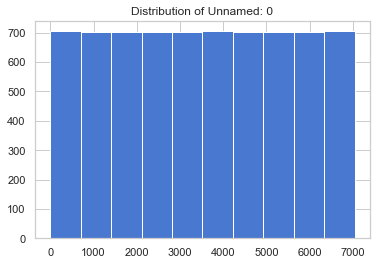

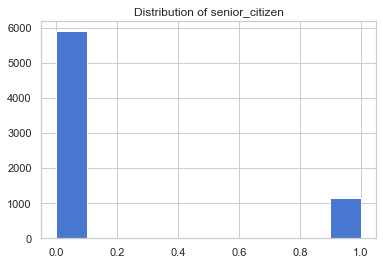

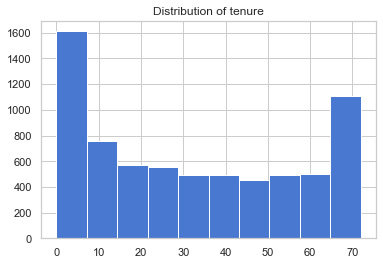

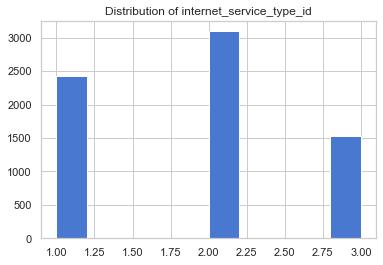

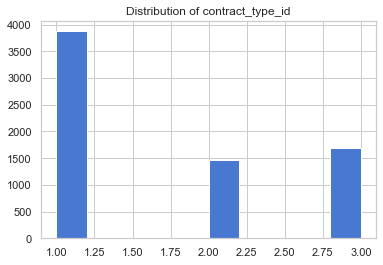

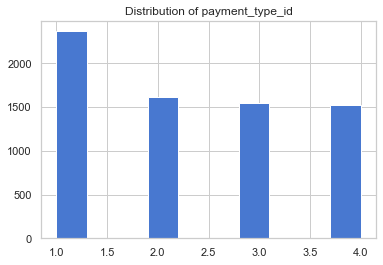

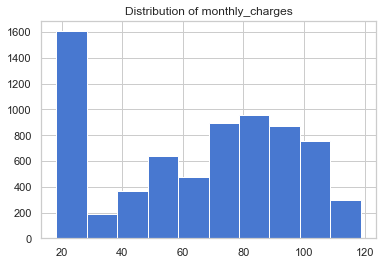

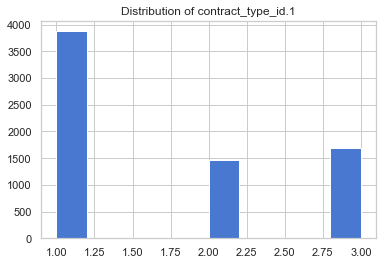

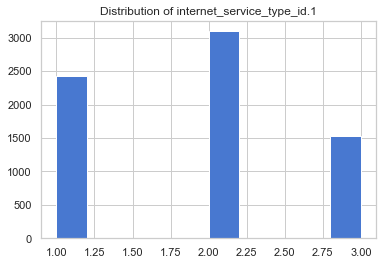

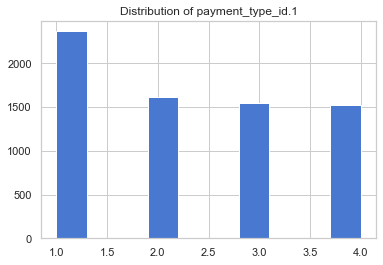

In [103]:
num_distributions(df)

### Acquire Takeaways
- I made the get_telco_data function that uses a SQL query to acquire my data from the Codeup database.
- Im bringing in 7043 rows and 28 columns after I joined the SQL tables together.
- The data has several types and will need alot of cleaning to get only numeric values.

## Prepare

I took the df and created numeric representations for the different values, I also added two columns (add_ons)
which takes a sum of the columns online_security, online_backup, device_protection, tech_support, streaming_tv,
and streaming_movies. I decided these were all additional services that customers opted into, and might be a driver of churn. My other column I added was (auto_pay) that took in the payment_type column and searched for the word "auto", and returns a boolean value.

In [104]:
df = clean_telco(df)

In [7]:
df.head(3)

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,payment_type_bank_transfer_(automatic),payment_type_credit_card_(automatic),payment_type_electronic_check,payment_type_mailed_check,internet_service_type_dsl,internet_service_type_fiber_optic,internet_service_type_none,contract_type_month-to-month,contract_type_one_year,contract_type_two_year
0,0,1,1,65,1,1,1,1,1,1,...,0,0,0,1,1,0,0,0,0,1
1,0,0,0,54,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
2,0,0,0,56,0,0,1,1,1,1,...,1,0,0,0,1,0,0,0,0,1


My decision to remove the customers with no tenure was that they were not good representations of our overall dataset having been with Telco for under 1 month.

These customers were a small percentage of the overall dataframe making up ~.15% of the overall data

In [8]:
# Takes those with no tenure and removes the customers data from the df.
remove_unwanted_values(df)

In [9]:
df.columns

Index(['senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'auto_pay', 'add_ons', 'streaming_movies_and_tv', 'gender_female',
       'gender_male', 'payment_type_bank_transfer_(automatic)',
       'payment_type_credit_card_(automatic)', 'payment_type_electronic_check',
       'payment_type_mailed_check', 'internet_service_type_dsl',
       'internet_service_type_fiber_optic', 'internet_service_type_none',
       'contract_type_month-to-month', 'contract_type_one_year',
       'contract_type_two_year'],
      dtype='object')

In [10]:
# split the data into 3 groups, while stratifying for our target variable (churn)
train,validate,test = train_validate_test_split(df,target = "churn", seed = 174)

In [11]:
print(f"Train {train.shape}, Validate {validate.shape},Test {test.shape}")

Train (3937, 31), Validate (1688, 31),Test (1407, 31)


## Explore

In [12]:
additionals = ['online_security', 'online_backup','device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
cat_vars = ["auto_pay","partner","add_ons","tech_support","online_security","senior_citizen","payment_type_electronic_check","internet_service_type_fiber_optic","streaming_tv","streaming_movies"]
quant_vars = ["monthly_charges","total_charges"]

It seems that those that have streaming services seem to churn more then what is normally seen, which might be indicating a lackluster set of streaming options or customer dissatisfaction with these services.

streaming_tv 
_____________________

        chi2   p-value  degrees of freedom
0  17.240002  0.000033                   1

observed:
 churn            0     1   All
streaming_tv                  
0             1851   593  2444
1             1040   453  1493
All           2891  1046  3937

expected:
              0           1
0  1794.667005  649.332995
1  1096.332995  396.667005


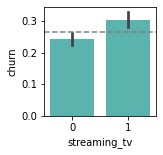


_____________________



In [13]:
explore.explore_bivariate_categorical(train,target = "churn",cat_var = 'streaming_tv')

streaming_movies 
_____________________

        chi2   p-value  degrees of freedom
0  12.822639  0.000342                   1

observed:
 churn                0     1   All
streaming_movies                  
0                 1812   589  2401
1                 1079   457  1536
All               2891  1046  3937

expected:
             0          1
0  1763.09144  637.90856
1  1127.90856  408.09144


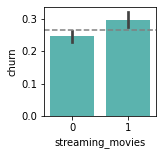


_____________________



In [14]:
explore.explore_bivariate_categorical(train,target = "churn",cat_var = 'streaming_movies')

<AxesSubplot:title={'center':'Features Correlation with Churn'}>

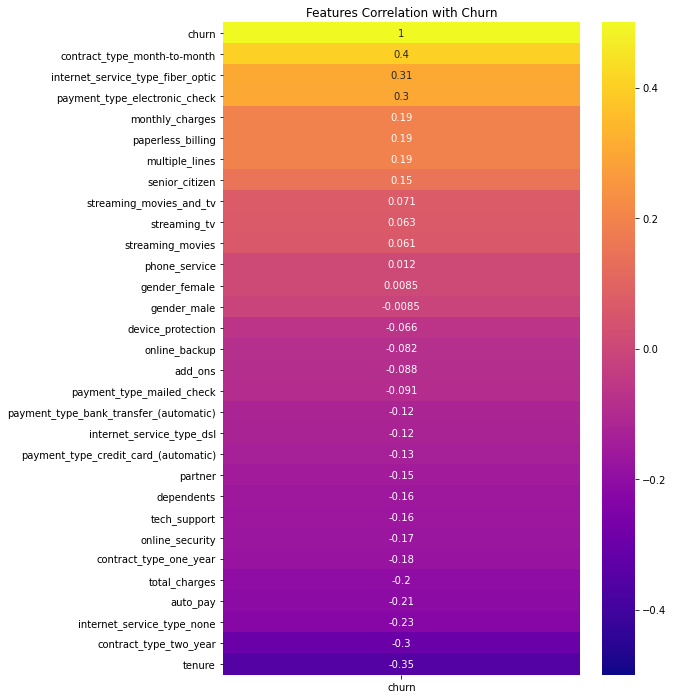

In [15]:
explore.telco_churn_heatmap(df)

#### best indicators of churn:
- Month-to-month contract type
- Fiber optics internet service type
- Electronic check payment type
- Tenure
- Two year contract type

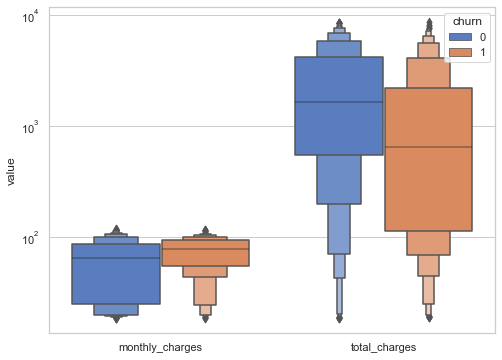

In [16]:
explore.plot_all_continuous_vars(train,target = "churn",quant_vars = quant_vars)

### Hypothesis
$H_O$ - The number of additional services and the likelyhood of churn are independent of eachother.

$H_A$ - The number of additional services and the likelyhood of churn are not independent of eachother.

α = .05

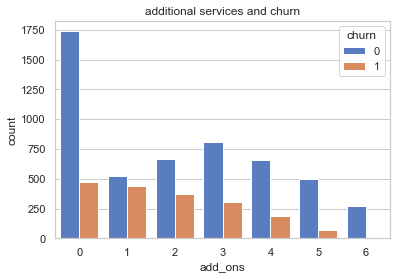

In [87]:
sns.countplot(data = df, hue = "churn", x = "add_ons")
plt.title("additional services and churn")
plt.show()

In [18]:
observed = pd.crosstab(train.add_ons,train.churn,margins = True)
observed

churn,0,1,All
add_ons,,,
0,986,266,1252
1,301,252,553
2,360,211,571
3,452,169,621
4,369,96,465
5,276,46,322
6,147,6,153
All,2891,1046,3937


In [19]:
chi2,p,degf,expected = stats.chi2_contingency(observed)
chi2,p,degf,expected

(225.69399141543363,
 2.9667698054486236e-40,
 14,
 array([[ 919.36296673,  332.63703327, 1252.        ],
        [ 406.07645415,  146.92354585,  553.        ],
        [ 419.29413259,  151.70586741,  571.        ],
        [ 456.00990602,  164.99009398,  621.        ],
        [ 341.45669291,  123.54330709,  465.        ],
        [ 236.4495809 ,   85.5504191 ,  322.        ],
        [ 112.3502667 ,   40.6497333 ,  153.        ],
        [2891.        , 1046.        , 3937.        ]]))

In [20]:
if p < α:
    print("We reject the null hypothesis")
    print("this is evidence to suggest that our alternative hypothesis is correct")
else:
    print("we failed to reject the null hypthesis")

We reject the null hypothesis
this is evidence to suggest that our alternative hypothesis is correct


### Hypothesis
$H_O$ - Streaming television and churn are independent of eachother.

$H_A$ - Streaming television and churn are not independent of eachother.

α = .05

streaming_tv 
_____________________

        chi2   p-value  degrees of freedom
0  17.240002  0.000033                   1

observed:
 churn            0     1   All
streaming_tv                  
0             1851   593  2444
1             1040   453  1493
All           2891  1046  3937

expected:
              0           1
0  1794.667005  649.332995
1  1096.332995  396.667005


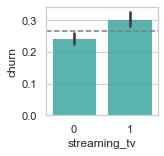


_____________________



In [78]:
explore.explore_bivariate_categorical(train,target = "churn",cat_var = 'streaming_tv')

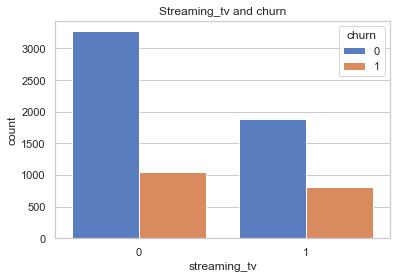

In [90]:
sns.countplot(data = df, hue = "churn", x = "streaming_tv")
plt.title("Streaming_tv and churn")
plt.show()

In [79]:
observed = pd.crosstab(train.streaming_tv,train.churn,margins = True)
observed

churn,0,1,All
streaming_tv,,,
0,1851,593,2444
1,1040,453,1493
All,2891,1046,3937


In [80]:
chi2,p,degf,expected = stats.chi2_contingency(observed)
chi2,p,degf,expected

(17.550162289611343,
 0.001510605465927347,
 4,
 array([[1794.66700533,  649.33299467, 2444.        ],
        [1096.33299467,  396.66700533, 1493.        ],
        [2891.        , 1046.        , 3937.        ]]))

In [81]:
if p < α:
    print("We reject the null hypothesis")
    print("this is evidence to suggest that our alternative hypothesis is correct")
else:
    print("we failed to reject the null hypthesis")

We reject the null hypothesis
this is evidence to suggest that our alternative hypothesis is correct


### Hypothesis
$H_O$ - Streaming movies and churn are independent of eachother.

$H_A$ - Streaming movies and churn are not independent of eachother.

α = .05

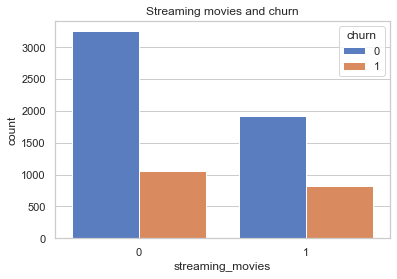

In [91]:
sns.countplot(data = df, hue = "churn", x = "streaming_movies")
plt.title("Streaming movies and churn")
plt.show()

streaming_movies 
_____________________

        chi2   p-value  degrees of freedom
0  12.822639  0.000342                   1

observed:
 churn                0     1   All
streaming_movies                  
0                 1812   589  2401
1                 1079   457  1536
All               2891  1046  3937

expected:
             0          1
0  1763.09144  637.90856
1  1127.90856  408.09144


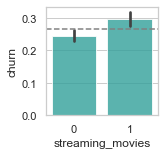


_____________________



In [82]:
explore.explore_bivariate_categorical(train,target = "churn",cat_var = 'streaming_movies')

In [83]:
observed = pd.crosstab(train.streaming_movies,train.churn,margins = True)
observed

churn,0,1,All
streaming_movies,,,
0,1812,589,2401
1,1079,457,1536
All,2891,1046,3937


In [25]:
chi2,p,degf,expected = stats.chi2_contingency(observed)
chi2,p,degf,expected

(13.088890714438502,
 0.01084952716720754,
 4,
 array([[1763.09144018,  637.90855982, 2401.        ],
        [1127.90855982,  408.09144018, 1536.        ],
        [2891.        , 1046.        , 3937.        ]]))

In [26]:
if p < α:
    print("We reject the null hypothesis")
    print("this is evidence to suggest that our alternative hypothesis is correct")
else:
    print("we failed to reject the null hypthesis")

We reject the null hypothesis
this is evidence to suggest that our alternative hypothesis is correct


### Hypothesis
$H_O$ - Streaming movies and tv are independent on churn.

$H_A$ - Streaming movies and tv are not independent of churn.

α = .05

In [ ]:
# 1 represents someone that has either movie or tv.

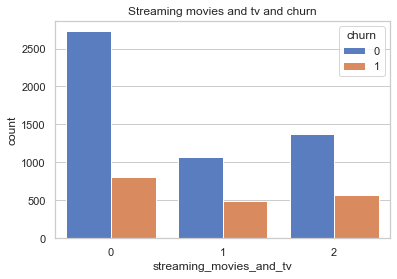

In [92]:
sns.countplot(data = df, hue = "churn", x = "streaming_movies_and_tv")
plt.title("Streaming movies and tv and churn")
plt.show()

In [31]:
observed = pd.crosstab(train.streaming_movies_and_tv,train.churn,margins = True)
observed

churn,0,1,All
streaming_movies_and_tv,,,
0,1527,449,1976
1,609,284,893
2,755,313,1068
All,2891,1046,3937


In [32]:
chi2,p,degf,expected = stats.chi2_contingency(observed)
chi2,p,degf,expected

(31.62705367777638,
 1.9235069410267655e-05,
 6,
 array([[1451.00736601,  524.99263399, 1976.        ],
        [ 655.74371349,  237.25628651,  893.        ],
        [ 784.2489205 ,  283.7510795 , 1068.        ],
        [2891.        , 1046.        , 3937.        ]]))

In [33]:
if p < α:
    print("We reject the null hypothesis")
    print("this is evidence to suggest that our alternative hypothesis is correct")
else:
    print("we failed to reject the null hypthesis")

We reject the null hypothesis
this is evidence to suggest that our alternative hypothesis is correct


### Takeaways

- There is evidence that the additional services and streaming services have an affect on the churn rate
- Our churn rates from our additional services (add_ons) needs further evaluation, churn rates for 1-2 services is much higher than expected, while churn rates of customers with 4-6 services have much lower rates of churn.
- The rates of churn of those that stream tv and movies are slightly higher, indicating that there is some kind of relationship.

### Reccomendations/More Inspection

- Are customers dissatisfied with our streaming services the data indicates so, do we offer a wide selection, user feedback would be a massive help, targeting those that churned to see if improvements could be made.
- Do we offer bundling for movies and streaming?
- The rates of churn are still higher then expected when customers have both streaming services, we might want to impliment a discount for customers that buy both services an entertainment bundle.

## Modeling and evaluation

 TP: Predicted customer retention and the customer stayed     | FP: Predicted customer retention and the customer left

 
 FN: Predicted our customer would leave and the customer didnt| TN: Predicted customer would leave and they did

In [44]:
# I am looking for a high accuracy in my model so I can accuratly identify who is likely to churn for future company
# projections, I also believe that good incite can be gathered from our FN and FP values and would reccomend
# survaying these groups to get a better understanding of customer satisfaction/dissatisfaction.

### Models

In [45]:
def baseline_acc(X,y, strategy = "most_frequent",random_state = 174):
    # generates a baseline model using most frequent, since there are only two outcomes we are predicting.
    model = DummyClassifier(strategy = strategy, random_state = random_state)
    model.fit(X,y)
    # prints an accuracy for the baseline model.
    print(f"Baseline accuracy score is: {model.score(X,y):.3%}")
    # Returns the baseline model back for use.
    return model


In [46]:
def tree_model(X,y,max_depth = 5, criterion = "gini", splitter = "best", random_state = 174):
    dt_model = DecisionTreeClassifier(max_depth = max_depth, criterion = criterion, splitter = splitter, random_state = random_state)
    dt_model.fit(X,y)
    y_pred = dt_model.predict(X)
    print(f"This decision tree models accuracy score is: {dt_model.score(X,y):.3%}")
    return dt_model,y_pred
 

In [47]:
def rand_forest(X,y, n_estimators = 30, criterion = "gini",max_depth = 9, random_state = 174, min_samples_leaf = 3):
    rf_model = RandomForestClassifier(
        n_estimators = n_estimators,
        criterion = criterion,
        max_depth = max_depth,
        min_samples_leaf = min_samples_leaf,
        random_state = random_state )
    rf_model.fit(X,y)
    y_pred = rf_model.predict(X)
    print(f"This Random Forest models accuracy score is: {rf_model.score(X,y):.3%}")
    return rf_model,y_pred


In [48]:
def knneighbors(X,y,n_neighbors = 5, weights = "uniform",leaf_size = 10,p = 2):
    knn_model = KNeighborsClassifier(
        n_neighbors = n_neighbors,
        weights = weights,
        leaf_size = leaf_size,
        p = p,)
    knn_model.fit(X,y)
    y_pred = knn_model.predict(X)
    print(f"This K Nearest Neighbor models accuracy score is: {knn_model.score(X,y):.3%}")
    return knn_model,y_pred


I created a function that returns 6 values an X that holds the dataframe while removing churn, and a y that holds the churn values for our train, validate, test.

In [65]:
X_train,y_train,X_validate,y_validate,X_test,y_test  = splitting_target_var(train,validate,test)

In [66]:
X_train.shape,y_train.shape,X_validate.shape,y_validate.shape,X_test.shape,y_test.shape

((3937, 30), (3937,), (1688, 30), (1688,), (1407, 30), (1407,))

### Train

### Baseline model
This uses most frequent as its strategy

In [67]:
baseline = baseline_acc(X_train,y_train)

Baseline accuracy score is: 73.432%


### Decision Tree
This model has a max depth of 5

In [68]:
dt_model,y_pred = tree_model(X_train,y_train)

This decision tree models accuracy score is: 79.553%


In [69]:
# This is a visualization of our Decision Tree model.

![](telco_decision_tree.pdf)

In [54]:
model_report(y_train,y_pred)


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: churn==1          |
|            Negative Case: churn==0          |
|---------------------------------------------|
|                 Accuracy:   79.55%          |
|       True Positive Rate:   56.15%          |
|      False Positive Rate:   18.97%          |
|       True Negative Rate:   81.03%          |
|      False Negative Rate:   43.85%          |
|                Precision:   62.72%          |
|                   Recall:   56.79%          |
|                 F1-Score:   59.61%          |
|                                             |
|         Positive Support:     1046          |
|         Negative Support:     2891          |
|            Total Support:     3937          |
|_____________________________________________|



In [55]:
rf_model,y_pred = rand_forest(X_train,y_train)

This Random Forest models accuracy score is: 84.455%


In [56]:
model_report(y_train,y_pred)


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: churn==1          |
|            Negative Case: churn==0          |
|---------------------------------------------|
|                 Accuracy:   84.46%          |
|       True Positive Rate:   68.63%          |
|      False Positive Rate:   18.83%          |
|       True Negative Rate:   81.17%          |
|      False Negative Rate:   31.37%          |
|                Precision:   76.53%          |
|                   Recall:   59.85%          |
|                 F1-Score:   67.17%          |
|                                             |
|         Positive Support:     1046          |
|         Negative Support:     2891          |
|            Total Support:     3937          |
|_____________________________________________|



In [57]:
knn_model,y_pred = knneighbors(X_train,y_train)

This K Nearest Neighbor models accuracy score is: 82.804%


In [58]:
model_report(y_train,y_pred)


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: churn==1          |
|            Negative Case: churn==0          |
|---------------------------------------------|
|                 Accuracy:   82.80%          |
|       True Positive Rate:   67.36%          |
|      False Positive Rate:   18.10%          |
|       True Negative Rate:   81.90%          |
|      False Negative Rate:   32.64%          |
|                Precision:   72.75%          |
|                   Recall:   56.41%          |
|                 F1-Score:   63.54%          |
|                                             |
|         Positive Support:     1046          |
|         Negative Support:     2891          |
|            Total Support:     3937          |
|_____________________________________________|



### Validate

In [59]:
accuracy = round(dt_model.score(X_validate, y_validate), 3)
print(f'Decision Tree model accuracy: {accuracy}')

Decision Tree model accuracy: 0.787


In [70]:
y_pred = dt_model.predict(X_validate)

In [71]:
model_report(y_validate,y_pred)


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: churn==1          |
|            Negative Case: churn==0          |
|---------------------------------------------|
|                 Accuracy:   78.73%          |
|       True Positive Rate:   54.04%          |
|      False Positive Rate:   19.19%          |
|       True Negative Rate:   80.81%          |
|      False Negative Rate:   45.96%          |
|                Precision:   60.71%          |
|                   Recall:   56.79%          |
|                 F1-Score:   58.69%          |
|                                             |
|         Positive Support:      449          |
|         Negative Support:     1239          |
|            Total Support:     1688          |
|_____________________________________________|



In [72]:
accuracy = round(rf_model.score(X_validate, y_validate), 3)
print(f'Random Forest model accuracy: {accuracy}')

Random Forest model accuracy: 0.807


In [73]:
y_pred = rf_model.predict(X_validate)

In [74]:
model_report(y_validate,y_pred)


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: churn==1          |
|            Negative Case: churn==0          |
|---------------------------------------------|
|                 Accuracy:   80.69%          |
|       True Positive Rate:   67.79%          |
|      False Positive Rate:   16.74%          |
|       True Negative Rate:   83.26%          |
|      False Negative Rate:   32.21%          |
|                Precision:   68.47%          |
|                   Recall:   50.78%          |
|                 F1-Score:   58.31%          |
|                                             |
|         Positive Support:      449          |
|         Negative Support:     1239          |
|            Total Support:     1688          |
|_____________________________________________|



In [75]:
accuracy = round(knn_model.score(X_validate, y_validate), 3)
print(f'K Nearest Neighbors model accuracy: {accuracy}')

K Nearest Neighbors model accuracy: 0.765


In [76]:
y_pred = knn_model.predict(X_validate)

In [77]:
model_report(y_validate,y_pred)


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: churn==1          |
|            Negative Case: churn==0          |
|---------------------------------------------|
|                 Accuracy:   76.54%          |
|       True Positive Rate:   66.41%          |
|      False Positive Rate:   14.40%          |
|       True Negative Rate:   85.60%          |
|      False Negative Rate:   33.59%          |
|                Precision:   58.31%          |
|                   Recall:   41.43%          |
|                 F1-Score:   48.44%          |
|                                             |
|         Positive Support:      449          |
|         Negative Support:     1239          |
|            Total Support:     1688          |
|_____________________________________________|



### Test

In [62]:
final_pred = make_predictions(rf_model,X_test)
model_report(y_test,final_pred)
print("\n")
print(f'Baseline model accuracy: {baseline.score(X_test, y_test):.2%}')


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: churn==1          |
|            Negative Case: churn==0          |
|---------------------------------------------|
|                 Accuracy:   80.67%          |
|       True Positive Rate:   69.49%          |
|      False Positive Rate:   16.30%          |
|       True Negative Rate:   83.70%          |
|      False Negative Rate:   30.51%          |
|                Precision:   69.03%          |
|                   Recall:   49.47%          |
|                 F1-Score:   57.63%          |
|                                             |
|         Positive Support:      374          |
|         Negative Support:     1033          |
|            Total Support:     1407          |
|_____________________________________________|



Baseline model accuracy: 73.42%


In [63]:
rf_model_score = rf_model.score(X_test,y_test)
baseline_score = baseline.score(X_test, y_test)
print(f"The total difference between the model I developed and the baseline was {(rf_model_score - baseline_score):.3%}")

The total difference between the model I developed and the baseline was 7.249%


In [64]:
# Saves a csv file of my predictions on the test data
get_final_report(knn_model)

,customer_id,prediction_proba,predictions
0,3030-YZADT,0.0,0
1,5131-PONJI,0.2,0
2,5343-SGUBI,0.0,0
3,1036-GUDCL,0.2,0
4,8731-WBBMB,0.2,0
...,...,...,...
1402,1984-FCOWB,0.2,0
1403,7663-RGWBC,0.2,0
1404,8644-XYTSV,0.2,0
1405,6937-GCDGQ,0.0,0


## Summary

### Key takeaways


top 5 churn predictors
- Month-to-month contract type
- Fiber optics internet service type
- Electronic check payment type
- Tenure
- Two year contract type
### Model takeaways
- The best model for accuracy was my decision tree model with an accuracy score of 80.67% on our test data.
- These are the model criteria that I used (n_estimators = 30, criterion = "gini",max_depth = 9, random_state = 174, min_samples_leaf = 3)

### Recommendations

- Although streaming was not the greatest indicator of churn I would still recommend further evaluation, and survaying of customers that had streaming services to gather their responses on why they churned.
- Offering some kind of incentive to bundle the streaming services at a small discount or improving on those services might lower churn.
- Investigate why customers are churning that have the fiber optics plan, is the price to high or is there some other factor causing it.
- Incentivise payment types other then electronic checks, in order to increase customer retention.

### Moving forward
If given more time

- I would adjust hyperperamaters and look for more features in the data, trying to find links between churn and multiple columns.
- I would also have a team focus on survaying customer complaints to find cheap fixes for any reoccuring drivers of churn.
- Additional effort in discovering the reason for the variations in churn for our add_ons column and discovering reasons for this data could give us actions we could use moving forward.